In [1]:
import re, urllib2, sys, BaseHTTPServer
import requests


def parseAddress(input):
        if input[:7] != "http://":
                if input.find("://") != -1:
                        print "Error: Cannot retrive URL, address must be HTTP"
                        sys.exit(1)
                else:
                        input = "http://" + input

        return input

def retrieveWebPage(address):
        web_handle = requests.get(address)
        return web_handle

In [2]:
import datetime
def past_newspapers(days):
    match_set = set()
    for i in range(days):
        target_date=datetime.datetime.now() + datetime.timedelta(-i)
        day=target_date.day
        month=target_date.month
        year=target_date.year
        address = parseAddress('http://www.nytimes.com/issue/todayspaper/'+str(year)+'/'+str(month)+'/'+str(day)+'/'+'todays-new-york-times')
        website_handle = retrieveWebPage(address)
        website_text = website_handle.text
        dir = website_handle.url.rsplit('/',1)[0].replace('section', '').replace('https','http')
        if (dir == "http:/"):
                dir = website_handle.url.replace('section', '')

        matches = re.findall('<a *href="(.*?)"', website_text)

        for match in matches:
            if '.html' in match:
                if match[:7] != "http://":
                        if match[0] == "/":
                                slash = ""
                        else:
                                slash = "/"
                        match_set.add('http://www.nytimes.com/'+ match.lstrip('/'))
                else:
                        match_set.add(match)
    match_set = list(match_set)
    match_set.sort()
    return match_set

In [3]:
match_set=past_newspapers(500)

In [4]:
len(match_set)

1668

In [5]:
from bs4 import BeautifulSoup

In [6]:
corpus=match_set

website_text=[]
for i in corpus:
    address = parseAddress(i)
    website_handle = retrieveWebPage(address)
    website_text.append(website_handle.text)


soup=[]
for i in website_text:
    soup.append(BeautifulSoup(i, 'html.parser'))

In [7]:
s=" "

corpus_text=[]
for j in xrange(len(soup)):
    seq=[]
    for i in soup[j].find_all('p'):
        seq.append(i.text)
    text= s.join(seq)
    corpus_text.append(text.replace('\n', ' ').replace('\r', ''))

In [9]:
with open('news.txt','wb') as file:
    for line in corpus_text:
        file.write(line.encode('utf-8'))
        file.write('\n')

In [20]:

import boto3
import sagemaker
from sagemaker import get_execution_role

role=get_execution_role()
sess=sagemaker.Session()

output_bucket='telcodemo-bucket'
s3 = boto3.resource('s3')

CPU times: user 228 ms, sys: 20.2 ms, total: 249 ms
Wall time: 370 ms


In [26]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role=get_execution_role()
sess=sagemaker.Session()

output_bucket='telcodemo-bucket'
s3 = boto3.resource('s3')
txt = open('news.txt', 'rb')
s3.Bucket(output_bucket).put_object(Key='topicmodel/input/news.txt', Body=txt)


import boto3
import json
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

n_topics=14
response = comprehend.start_topics_detection_job(
    NumberOfTopics=n_topics,
    JobName = n_topics_'_Topic_Model',
    InputDataConfig={
        'S3Uri': 's3://telcodemo-bucket/topicmodel/input/news.txt',
        'InputFormat':'ONE_DOC_PER_LINE'
    },
    OutputDataConfig={
        'S3Uri': 's3://telcodemo-bucket/topicmodel/output/'
    },
    DataAccessRoleArn=role
)



CPU times: user 211 ms, sys: 33.1 ms, total: 244 ms
Wall time: 563 ms


In [27]:
print(response)

{'ResponseMetadata': {'RetryAttempts': 0, 'HTTPStatusCode': 200, 'RequestId': '946aabbb-ea72-11e8-bff5-292563ac9744', 'HTTPHeaders': {'date': 'Sat, 17 Nov 2018 14:10:47 GMT', 'x-amzn-requestid': '946aabbb-ea72-11e8-bff5-292563ac9744', 'content-length': '68', 'content-type': 'application/x-amz-json-1.1', 'connection': 'keep-alive'}}, u'JobStatus': u'SUBMITTED', u'JobId': u'16ecf8ac3b8d809f55eb2dbb79a71262'}


In [30]:
describe = comprehend.describe_topics_detection_job(
    JobId='16ecf8ac3b8d809f55eb2dbb79a71262'
)
print(describe)

{u'TopicsDetectionJobProperties': {u'InputDataConfig': {u'S3Uri': u's3://telcodemo-bucket/topicmodel/input/news.txt', u'InputFormat': u'ONE_DOC_PER_LINE'}, u'NumberOfTopics': 14, u'JobStatus': u'COMPLETED', u'JobId': u'16ecf8ac3b8d809f55eb2dbb79a71262', u'SubmitTime': datetime.datetime(2018, 11, 17, 14, 10, 47, 247000, tzinfo=tzlocal()), u'OutputDataConfig': {u'S3Uri': u's3://telcodemo-bucket/topicmodel/output/349934754982-TOPICS-16ecf8ac3b8d809f55eb2dbb79a71262/output/output.tar.gz'}, u'EndTime': datetime.datetime(2018, 11, 17, 14, 15, 25, 25000, tzinfo=tzlocal())}, 'ResponseMetadata': {'RetryAttempts': 0, 'HTTPStatusCode': 200, 'RequestId': 'c107ea21-ea73-11e8-bad3-254cf7dd0db9', 'HTTPHeaders': {'date': 'Sat, 17 Nov 2018 14:19:11 GMT', 'x-amzn-requestid': 'c107ea21-ea73-11e8-bad3-254cf7dd0db9', 'content-length': '434', 'content-type': 'application/x-amz-json-1.1', 'connection': 'keep-alive'}}}


In [32]:
!aws s3 cp s3://telcodemo-bucket/topicmodel/output/349934754982-TOPICS-16ecf8ac3b8d809f55eb2dbb79a71262/output/output.tar.gz .

download: s3://telcodemo-bucket/topicmodel/output/349934754982-TOPICS-16ecf8ac3b8d809f55eb2dbb79a71262/output/output.tar.gz to ./output.tar.gz


In [34]:
!tar -xvzf output.tar.gz

topic-terms.csv
doc-topics.csv


In [138]:
import pandas as pd
topic= pd.read_csv('topic-terms.csv')
docs=pd.read_csv('doc-topics.csv')

In [102]:
topic[topic['topic']==13]

,topic,term,weight
130,13,tax,0.044640
131,13,cut,0.016301
132,13,bill,0.015700
133,13,taxis,0.012111
134,13,percent,0.013482
135,13,income,0.007848
136,13,rate,0.008169
137,13,republican,0.010490
138,13,pay,0.008439
139,13,year,0.013460


In [139]:
docs.sort_values(['docname', 'proportion'], ascending=[1, 0]).head(10)

,docname,topic,proportion
5965,news.txt:0,4,0.781641
5966,news.txt:0,8,0.213469
5967,news.txt:0,7,0.004890
5172,news.txt:1,4,0.881490
5173,news.txt:1,0,0.115148
5174,news.txt:1,2,0.003361
1383,news.txt:10,0,0.655876
1384,news.txt:10,1,0.146967
1385,news.txt:10,4,0.104721
1386,news.txt:10,3,0.064937


In [141]:
doc_topic=docs.groupby(['docname'],sort=True)['proportion','topic'].max()

In [142]:
doc_topic.index = doc_topic.index.str.strip('news.txt:').astype(int)

In [143]:
doc_topic=doc_topic.sort_index()

In [147]:
doc_topic['topic'][98]

12

In [128]:
with open('labeled_news.txt','wb') as file:
    k=0
    for line in corpus_text:
        file.write('topic '+str(doc_topic['topic'][k])+', "'+line.replace(',','')+'"')
        file.write('\n')
        k=k+1

In [129]:
txt = open('labeled_news.txt', 'rb')
s3.Bucket(output_bucket).put_object(Key='classifier/input/labelednews.txt', Body=txt)

s3.Object(bucket_name='telcodemo-bucket', key='classifier/input/labelednews.txt')

In [135]:
txt = open('labeled_news.txt', 'rb')

In [137]:
txt

<open file 'labeled_news.txt', mode 'rb' at 0x7f464145e6f0>

In [130]:
corpus_text[39]

'Supported by By Eric Schmitt ABOARD A B-52, over Eastern Afghanistan \xe2\x80\x94 Flying at more than 20,000 feet, the hulking long-range bomber circled ominously above a militant-infested swath of Afghan territory near the rugged border with Pakistan, hunting for Taliban or Islamic State fighters who could threaten friendly troops nearby. A ride in the cockpit on a recent 13-hour combat mission provided a rare bird\xe2\x80\x99s-eye view of the Trump administration\xe2\x80\x99s newly revamped Afghanistan policy of sending thousands of additional American troops closer to the front lines \xe2\x80\x94 and more warplanes like this one to protect them. That includes striking Taliban drug depots to cripple the group\xe2\x80\x99s financial lifeline, as the Pentagon did in Iraq and Syria in hitting the Islamic State\xe2\x80\x99s oil tankers and cash-storage sites. During the Obama administration, American commanders were barred from carrying out offensive airstrikes against the Taliban. Atta

In [132]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role=get_execution_role()
sess=sagemaker.Session()

output_bucket='telcodemo-bucket'
s3 = boto3.resource('s3')

import json
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

doc_classifier = comprehend.create_document_classifier(
    DocumentClassifierName= 'news_classifier',
    InputDataConfig={
        'S3Uri': 's3://telcodemo-bucket/classifier/input/labeled_news.txt',
        'InputFormat':'ONE_DOC_PER_LINE'
    },
    DataAccessRoleArn=role,
    LanguageCode='en'
)


AttributeError: 'Comprehend' object has no attribute 'create_document_classifier'

In [134]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role=get_execution_role()
sess=sagemaker.Session()

output_bucket='telcodemo-bucket'
s3 = boto3.resource('s3')

import json
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

response = comprehend.start_document_classification_job(
    JobName='classificaion_job',
    DocumentClassifierArn='16ecf8ac3b8d809f55eb2dbb79a71262',
    InputDataConfig={
        'S3Uri': 's3://telcodemo-bucket/classifier/input/labeled_news.txt',
        'InputFormat': 'ONE_DOC_PER_LINE'
    },
    OutputDataConfig={
        'S3Uri': 's3://telcodemo-bucket/classifier/output/'
    },
    DataAccessRoleArn='string',
    ClientRequestToken='string'
)


AttributeError: 'Comprehend' object has no attribute 'start_document_classification_job'

In [10]:
!pip install stop_words

  Running setup.py bdist_wheel for stop-words ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install stop_words

mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [39]:
from stop_words import get_stop_words

stop_words = get_stop_words('english')
stop_words.append("u'ms'")
stop_words.append("u'mr'")
stop_words.append("ms")
stop_words.append("mr")
stop_words.append("ms.")
stop_words.append("mr.")
stop_words.append("u'ms.'")
stop_words.append("u'mr.'")
stop_words.append("will")
stop_words.append("said")
stop_words.append("u'will")
stop_words.append("u'said")
print(list(stop_words))

[u'a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u"aren't", u'as', u'at', u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', u"can't", u'cannot', u'could', u"couldn't", u'did', u"didn't", u'do', u'does', u"doesn't", u'doing', u"don't", u'down', u'during', u'each', u'few', u'for', u'from', u'further', u'had', u"hadn't", u'has', u"hasn't", u'have', u"haven't", u'having', u'he', u"he'd", u"he'll", u"he's", u'her', u'here', u"here's", u'hers', u'herself', u'him', u'himself', u'his', u'how', u"how's", u'i', u"i'd", u"i'll", u"i'm", u"i've", u'if', u'in', u'into', u'is', u"isn't", u'it', u"it's", u'its', u'itself', u"let's", u'me', u'more', u'most', u"mustn't", u'my', u'myself', u'no', u'nor', u'not', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'ought', u'our', u'ours', u'ourselves', u'out', u'over', u'own', u'same', u"shan't", u'she', u"she'd", u"she'll", u"she's", u'should', u"

In [40]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
corpus_text=lines = [line.rstrip('\n') for line in open('news.txt')]

In [41]:
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words,
                             tokenizer=LemmaTokenizer(), ngram_range=(1,3), max_features=vocab_size, max_df=0.95, min_df=0.1)
vectors = vectorizer.fit_transform(corpus_text)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))



Tokenizing and counting, this may take a few minutes...
('vocab size:', 853)
Done. Time elapsed: 54.04s


In [42]:
vectors

<1668x853 sparse matrix of type '<type 'numpy.float64'>'
	with 290742 stored elements in Compressed Sparse Row format>

In [90]:
threshold = 25
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print('removed short docs (<{} words)'.format(threshold))        
print(vectors.shape)

removed short docs (<25 words)
(0, 856)


In [43]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)


(<class 'scipy.sparse.csr.csr_matrix'>, dtype('float32'))


In [44]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [45]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

((1334, 853), (167, 853), (167, 853))


In [46]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'telcodemo-bucket'
prefix = 'ntm'

aux_prefix = os.path.join(prefix, 'auxiliary')
train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_aux_data= os.path.join('s3://', bucket, aux_prefix)
s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

('Training set location', 's3://telcodemo-bucket/ntm/train')
('Validation set location', 's3://telcodemo-bucket/ntm/val')
('Trained model will be saved at', 's3://telcodemo-bucket/ntm/output')


In [47]:
with open('vocab.txt','wb') as file:
    for line in vocab_list:
        file.write(line.encode('utf-8'))
        file.write('\n')

In [48]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [49]:
!aws s3 ls s3://telcodemo-bucket/ntm/auxiliary/

2018-11-17 16:45:57       5298 vocab.txt


In [50]:

voc = open('vocab.txt', 'rb')
s3.Bucket(bucket).put_object(Key=aux_prefix+'/vocab.txt', Body=voc)
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://telcodemo-bucket/ntm/train/train_part0.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part1.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part2.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part3.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part4.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part5.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part6.pbr
Uploaded data to s3://telcodemo-bucket/ntm/train/train_part7.pbr
Uploaded data to s3://telcodemo-bucket/ntm/val/val_part0.pbr


In [51]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

In [52]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.p3.2xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

In [53]:
num_topics = 14
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=853, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

In [54]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key')
s3_aux = s3_input(s3_aux_data, distribution='FullyReplicated', content_type='text/plain')


In [55]:
ntm.fit({'train': s3_train, 'test': s3_val_data,'auxiliary': s3_aux})

INFO:sagemaker:Creating training-job with name: ntm-2018-11-17-17-05-38-808


2018-11-17 17:05:38 Starting - Starting the training job...
2018-11-17 17:05:42 Starting - Launching requested ML instances......
2018-11-17 17:06:58 Starting - Preparing the instances for training......
2018-11-17 17:08:03 Downloading - Downloading input data...
2018-11-17 17:08:37 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[11/17/2018 17:08:31 INFO 140272133961536] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'sub_sample': u'1.0', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'toler

[11/17/2018 17:08:44 WARNING 140272133961536] 26 out of 853 in vocabulary do not have embeddings! Default vector used for unknown embedding!
[11/17/2018 17:08:44 INFO 140272133961536] Vocab embedding shape
[11/17/2018 17:08:44 INFO 140272133961536] Number of GPUs being used: 1
[11/17/2018 17:08:51 WARNING 140176468125504] 26 out of 853 in vocabulary do not have embeddings! Default vector used for unknown embedding!
[11/17/2018 17:08:51 INFO 140176468125504] Vocab embedding shape
[11/17/2018 17:08:51 INFO 140176468125504] Number of GPUs being used: 1

2018-11-17 17:09:09 Uploading - Uploading generated training model[11/17/2018 17:08:55 INFO 140272133961536] Create Store: dist_async_device
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count":

[11/17/2018 17:09:04 INFO 140176468125504] # Finished training epoch 23 on 670 examples from 6 batches, each of size 128.
[11/17/2018 17:09:04 INFO 140176468125504] Metrics for Training:
[11/17/2018 17:09:04 INFO 140176468125504] Loss (name: value) total: 5.77549052238
[11/17/2018 17:09:04 INFO 140176468125504] Loss (name: value) kld: 3.35395451051e-05
[11/17/2018 17:09:04 INFO 140176468125504] Loss (name: value) recons: 5.77545710405
[11/17/2018 17:09:04 INFO 140176468125504] Loss (name: value) logppx: 5.77549052238
[11/17/2018 17:09:04 INFO 140176468125504] #quality_metric: host=algo-2, epoch=23, train total_loss <loss>=5.77549052238
[11/17/2018 17:09:04 INFO 140176468125504] patience losses:[5.7797511021296186, 5.7800239721934004, 5.7783363660176592, 5.7785855134328203, 5.7766980727513628] min patience loss:5.77669807275 current loss:5.77549052238 absolute loss difference:0.00120755036672
[11/17/2018 17:09:04 INFO 140176468125504] Timing: train: 0.14s, val: 0.01s, epoch: 0.15s
[11/1


2018-11-17 17:09:16 Completed - Training job completed
Billable seconds: 147


In [57]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: ntm-2018-11-17-17-13-50-206
INFO:sagemaker:Creating endpoint with name ntm-2018-11-17-17-05-38-808


---------------------------------------------------------------------------!

In [58]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

In [59]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

{u'predictions': [{u'topic_weights': [0.0714320838, 0.0711237788, 0.0717809349, 0.0713732615, 0.0715249702, 0.0717608854, 0.0717098117, 0.0711141452, 0.0717285052, 0.0710526034, 0.0709605291, 0.0715662315, 0.0708968863, 0.0719753876]}, {u'topic_weights': [0.0714240968, 0.0711168721, 0.0717764348, 0.0713696554, 0.0715376958, 0.0717720091, 0.0717121214, 0.0711113811, 0.0717110559, 0.0710564554, 0.0709516034, 0.0715639368, 0.0709215626, 0.0719750896]}, {u'topic_weights': [0.071430333, 0.0711226836, 0.0717831254, 0.0713708252, 0.071522288, 0.0717598125, 0.0717116147, 0.0711149499, 0.0717320442, 0.0710502863, 0.0709635615, 0.0715684295, 0.0708927438, 0.0719773099]}, {u'topic_weights': [0.0714253187, 0.0711197481, 0.0717767626, 0.0713709071, 0.0715323761, 0.0717715099, 0.0717110038, 0.071114257, 0.0717170089, 0.0710548162, 0.0709576905, 0.0715631768, 0.0709109157, 0.0719745457]}, {u'topic_weights': [0.0714298412, 0.0711215138, 0.0717805251, 0.071371384, 0.0715254024, 0.0717623383, 0.07170928

In [126]:
vocab_list

[u'ability',
 u'able',
 u'according',
 u'account',
 u'accused',
 u'act',
 u'action',
 u'actually',
 u'added',
 u'adding',
 u'addition',
 u'address',
 u'administration',
 u'age',
 u'agency',
 u'ago',
 u'agreed',
 u'ahead',
 u'air',
 u'allow',
 u'allowed',
 u'america',
 u'american',
 u'andrew',
 u'angeles',
 u'announced',
 u'answer',
 u'appeared',
 u'appears',
 u'approach',
 u'area',
 u'arrived',
 u'art',
 u'article',
 u'ask',
 u'asked',
 u'attack',
 u'attempt',
 u'attention',
 u'audience',
 u'august',
 u'author',
 u'authority',
 u'average',
 u'away',
 u'bad',
 u'bank',
 u'base',
 u'based',
 u'began',
 u'begin',
 u'beginning',
 u'believe',
 u'benefit',
 u'best',
 u'better',
 u'big',
 u'biggest',
 u'billion',
 u'bit',
 u'black',
 u'board',
 u'body',
 u'book',
 u'born',
 u'break',
 u'bring',
 u'brooklyn',
 u'brother',
 u'brought',
 u'build',
 u'building',
 u'built',
 u'business',
 u'buy',
 u'california',
 u'called',
 u'calling',
 u'came',
 u'campaign',
 u'candidate',
 u'capital',
 u'car',


In [60]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[ 0.07143208  0.07112378  0.07178093  0.07137326  0.07152497  0.07176089
   0.07170981  0.07111415  0.07172851  0.0710526   0.07096053  0.07156623
   0.07089689  0.07197539]
 [ 0.0714241   0.07111687  0.07177643  0.07136966  0.0715377   0.07177201
   0.07171212  0.07111138  0.07171106  0.07105646  0.0709516   0.07156394
   0.07092156  0.07197509]
 [ 0.07143033  0.07112268  0.07178313  0.07137083  0.07152229  0.07175981
   0.07171161  0.07111495  0.07173204  0.07105029  0.07096356  0.07156843
   0.07089274  0.07197731]
 [ 0.07142532  0.07111975  0.07177676  0.07137091  0.07153238  0.07177151
   0.071711    0.07111426  0.07171701  0.07105482  0.07095769  0.07156318
   0.07091092  0.07197455]
 [ 0.07142984  0.07112151  0.07178053  0.07137138  0.0715254   0.07176234
   0.07170928  0.07111734  0.07172777  0.07105288  0.07096341  0.07156616
   0.07089703  0.07197506]]


In [61]:
import mxnet as mx

In [62]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'ntm/output/ntm-2018-11-17-17-05-38-808/output/model.tar.gz'

In [63]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [64]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [65]:
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


In [66]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

In [67]:
!pip install wordcloud
import wordcloud as wc

    100% |████████████████████████████████| 348kB 23.7MB/s ta 0:00:01
mxnet-model-server 0.4 requires mxnet-mkl>=1.2, which is not installed.
mxnet-model-server 0.4 has requirement onnx==1.1.1, but you'll have onnx 1.2.1 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


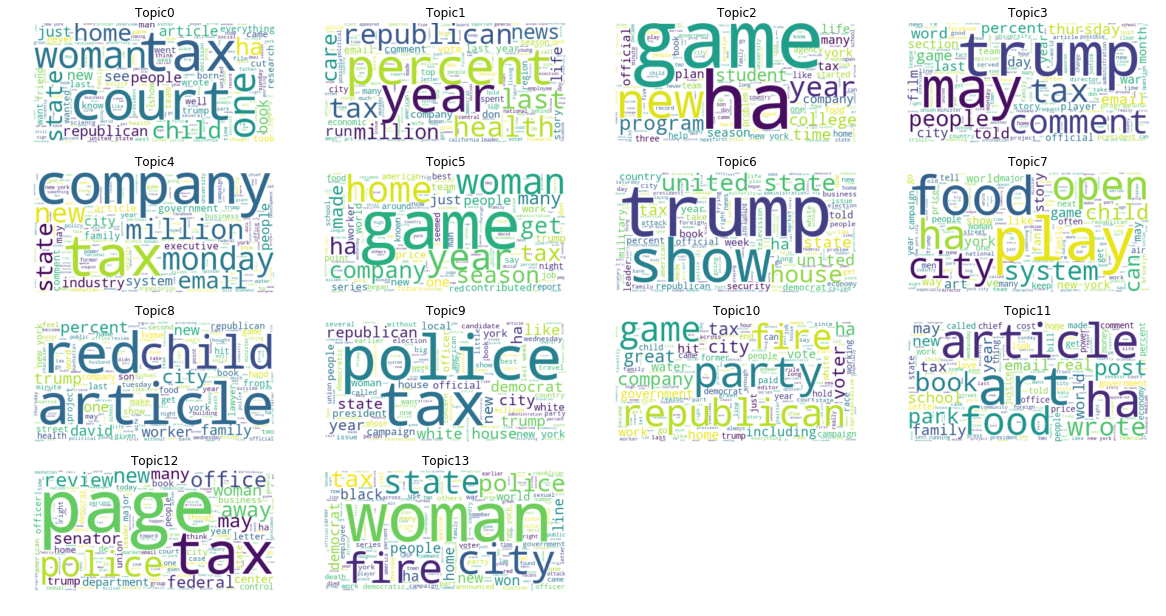

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline  

word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
plt.show()

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0.1, stop_words = stop_words)
X = vectorizer.fit_transform(corpus_text)

In [16]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_topics = 14
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()




# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_df=0.95, min_df=2, stop_words = stop_words)
t0 = time()
tfidf = vectorizer.fit_transform(corpus_text)
print("done in %0.3fs." % (time() - t0))


# Fit the NMF model
print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
exit()
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 18.034s.
Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
done in 7.908s.

Topics in NMF model:
Topic #0:
new one people like can year city years just also york new york time two many now first company re even
Topic #1:
nytimes nytimes com com 698 844 errors 800 comments article misstated email delivery questions 212 556 3622 nytimes 800 212 556 844 698 call 844 nyt nytimes 800 698 call 844 nytimes com faxed
Topic #2:
sox red sox dodgers game red series world series inning boston yankees brewers cora baseball season astros machado innings games postseason pitcher
Topic #3:
saudi khashoggi arabia saudi arabia prince crown prince crown mohammed prince mohammed kingdom saudis turkish iran turkey yemen erdogan killing consulate istanbul riyadh
Topic #4:
democrats republican republicans democratic voters election trump senate party campaign vote candidates race state governor races sinema votes representative hous